In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from urllib.parse import unquote
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('data/csv/our_mtcnn_new.csv')  

In [3]:
data.head()

,Emotion,left_eye d,left_eye a,right_eye d,right_eye a,nose d,nose a,mouth_left d,mouth_left a,mouth_right d,mouth_right a
0,0,13.813037,-124.380345,13.446189,-67.249024,1.000000,143.130102,14.317821,118.354962,14.710540,46.101706
1,0,12.006665,-119.981639,11.651609,-39.427802,3.310589,-154.983107,10.824047,117.512003,10.824047,62.487997
2,0,11.539497,-115.676816,12.006665,-60.018361,1.166190,149.036243,11.320777,122.005383,12.180312,60.488501
3,0,13.453624,-131.987212,12.727922,-45.000000,5.385165,-68.198591,17.804494,128.157227,13.453624,48.012788
4,0,12.088011,-128.955908,10.560303,-52.696052,1.523155,23.198591,10.262553,123.070678,10.154802,57.875002


In [4]:
features = ['left_eye d', 'left_eye a', 'right_eye d', 'right_eye a', 'nose d', 'nose a', 'mouth_left d', 'mouth_left a', 'mouth_right d', 'mouth_right a']
# Separating out the features
x = data.loc[:, features].values
# Separating out the target
y = data.loc[:,['Emotion']].values
# Standardizing the features
#x = MinMaxScaler().fit_transform(x)

In [5]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [6]:
finalDf = pd.concat([principalDf, data[['Emotion']]], axis = 1)

In [7]:
x1,y1 = np.array(finalDf.loc[finalDf['Emotion'] == 1])[:,:2].T
x0,y0 = np.array(finalDf.loc[finalDf['Emotion'] == 0])[:,:2].T


In [8]:
x

array([[  13.81303732, -124.38034472,   13.44618905, ...,  118.35496179,
          14.71054044,   46.10170612],
       [  12.00666482, -119.98163937,   11.65160933, ...,  117.51200262,
          10.8240473 ,   62.48799738],
       [  11.53949739, -115.67681568,   12.00666482, ...,  122.00538321,
          12.18031198,   60.48850144],
       ...,
       [  10.37111373, -129.52263127,    9.65194281, ...,  121.8907918 ,
          10.92520023,   66.25050551],
       [  13.73608387, -132.04922089,   11.73371212, ...,  122.64464013,
          17.52369824,   51.95295747],
       [  13.17118066, -131.9225446 ,   13.56023599, ...,  121.26373169,
          12.8015624 ,   61.03233935]])

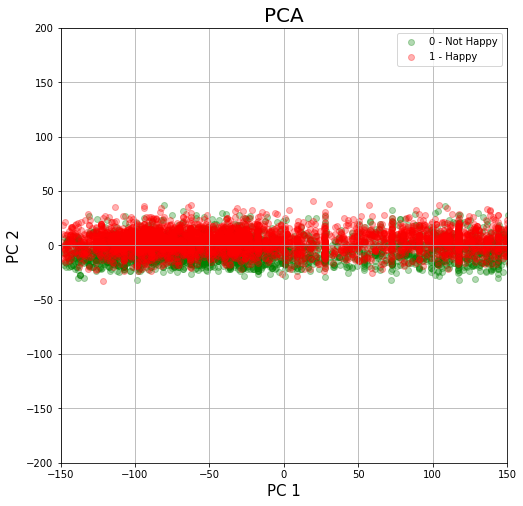

In [9]:
fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
ax.axis([-150, 150, -200, 200])
targets = ['0 - Not Happy', '1 - Happy']
colors = ['r', 'g']
ax.scatter(x1, y1, c = colors[1], alpha=0.3)

ax.scatter(x0, y0, c = colors[0], alpha=0.3)
ax.legend(targets)
ax.grid()

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [11]:
def load_data(path):
    df = pd.read_csv(path)
    data = df.drop(["Emotion"], axis=1)
    labels = df["Emotion"]
    x_train, x_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.2, shuffle=True)
    return x_train, y_train, x_test, y_test

In [ ]:
clf = SVC(kernel='linear', probability=True, tol=1e-3)
training_data, training_labels, prediction_data, prediction_labels = load_data('data/csv/our_mtcnn_new.csv')

npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
npar_trainlabs = np.array(training_labels)

model = clf.fit(npar_train, training_labels)

y_pred = clf.predict(prediction_data)

print("Accuracy", metrics.accuracy_score(prediction_labels, y_pred))


In [ ]:
y_pred_proba = clf.predict_proba(prediction_data)[::,1]
fpr, tpr, _ = metrics.roc_curve(prediction_labels,  y_pred_proba)
auc = metrics.roc_auc_score(prediction_labels, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:

lr_precision, lr_recall, _ = metrics.precision_recall_curve(prediction_labels, y_pred_proba)
lr_f1, lr_auc = metrics.f1_score(prediction_labels, y_pred), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('SVM: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
happy = len(prediction_labels[prediction_labels==1]) / len(prediction_labels)
plt.plot([0, 1], [happy, happy], linestyle='--', label='Happy')
plt.plot(lr_recall, lr_precision, marker='.', label='SVM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:

cf_matrix = metrics.confusion_matrix(prediction_labels, y_pred)
print(metrics.classification_report(prediction_labels, y_pred))


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');